## Setup

In [1]:
source("2022_PSVD_metabolomics/2022_PSVD_metabolomics/R/00_setup.R")
source("analysis/099_functions.R")

In [2]:
p_load("dplyr", "ggplot2", "caret", "mlbench", "pROC", install = FALSE)

In [3]:
metabol <- read.csv("outputs/01_metabolomics_merged.csv")
metabol <- metabol[2:ncol(metabol)]
metadata <- read.csv("outputs/01_metadata.csv")
metadata <- metadata[2:ncol(metadata)]

metabolites_mapped <- read.csv("outputs/01_metabolites_mapped.csv")

In [4]:
metabol_annot <- metabol %>% as.matrix() %>% t() %>% as.data.frame() %>% janitor::row_to_names(row_number = 1) %>% tibble::rownames_to_column("sample_id")

metabol_annot <- metabol_annot %>% filter(sample_id %in% metabolites_mapped$HMDB) %>% arrange(sample_id)

metabolites_mapped <- metabolites_mapped %>% filter(HMDB %in% metabol_annot$sample_id) %>% distinct(HMDB, .keep_all = TRUE) %>% arrange(HMDB)

metabol_annot$sample_id <- metabolites_mapped$name_corrected

## Feature preparation

In [7]:
cir_cneg <- read.csv("outputs/02_cir_cneg")
psvd_cir <- read.csv("outputs/02_psvd_cir")
psvd_cneg <- read.csv("outputs/02_psvd_cneg")

In [214]:
psvd_cir_sel <- psvd_cir %>% filter(adj.P.Val < 0.05)
psvd_cneg_sel <- psvd_cneg %>% filter(adj.P.Val < 0.05) %>% select(-B) %>% top_frac(.2)

Selecting by adj.P.Val


In [9]:
dm_vector <- c(psvd_cneg_sel$feature, psvd_cir_sel$feature) %>% unique()
dm_vector <- dm_vector[ !dm_vector == 'Cholic']

In [10]:
pc1_top <- read.csv(file = "outputs/03_pc1_top.csv")
pc1_bot <- read.csv(file = "outputs/03_pc1_bpt.csv")
pc4_top <- read.csv(file = "outputs/03_pc4_top.csv")
pc4_bot <- read.csv(file = "outputs/03_pc4_bot.csv")

In [11]:
pc1_top <- pc1_top$x
pc1_bot <- pc1_bot$x

pc4_top <- pc4_top$x
pc4_bot <- pc4_bot$x

## PSVD vs HC

### feature selection

In [12]:

dm_map <- metabolites_mapped %>% filter(name_corrected %in% dm_vector)

In [13]:
dm_metabol <- metabol %>% select(c(sample_id, dm_map$HMDB))

In [14]:
metadata_psvd_cneg <- metadata %>% filter(group_123 %in% c(1, 3))
metadata_psvd_cneg <- metadata_psvd_cneg %>% dplyr::select(-c(sample_description, group_gen, drug_induced))
dm_metabol <- dm_metabol %>% select_if(~ !any(is.na(.)))
metadata_psvd_cneg <- metadata_psvd_cneg %>% select_if(~ !any(is.na(.)))
metadata_psvd_cneg <- merge(metadata_psvd_cneg, dm_metabol, by = "sample_id")
metadata_psvd_cneg$group_123 <- as.factor(metadata_psvd_cneg$group_123)
x_train <- metadata_psvd_cneg[,-2]
y_train <- metadata_psvd_cneg[, 2]
     
control_rfe_disease_staging = rfeControl(functions = nbFuncs, # random forest
                      method = "repeatedcv", # repeated cv
                      repeats = 5, # number of repeats
                      number = 10) # number of folds

set.seed(42)
# Performing RFE
defaultW <- getOption("warn") 
options(warn = -1)
result_rfe_disease_staging = rfe(x = x_train %>% dplyr::select(-sample_id), 
                 y = y_train, 
                 sizes = c(1:10),
                 rfeControl = control_rfe_disease_staging)

# result_rfe_disease_staging = train(x = x_train_disease_staging %>% dplyr::select(-Sample_id), 
#                  method = "rf",
#                  y = y_train_disease_staging, 
#                  sizes = c(1:10),
#                  trControl = control_rfe_disease_staging)

# summarising the results
result_rfe_disease_staging
options(warn = defaultW)
result_rfe_disease_staging$optVariables
result_rfe_disease_staging$optVariables %>% as.vector()


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy Kappa AccuracySD KappaSD Selected
         1    0.775  0.55     0.1907  0.3813         
         2    0.890  0.78     0.1529  0.3057         
         3    0.900  0.80     0.1429  0.2857         
         4    0.910  0.82     0.1313  0.2626         
         5    0.880  0.76     0.1535  0.3071         
         6    0.915  0.83     0.1299  0.2597         
         7    0.900  0.80     0.1429  0.2857         
         8    0.895  0.79     0.1523  0.3046         
         9    0.895  0.79     0.1437  0.2873         
        10    0.895  0.79     0.1523  0.3046         
        29    0.935  0.87     0.1108  0.2215        *

The top 5 variables (out of 29):
   HMDB0000036, HMDB0000191, HMDB0000299, HMDB0000448, HMDB0007890


[1] "HMDB0000036" "HMDB0000191" "HMDB0000299" "HMDB0000448" "HMDB0007890"
 [6] "HMDB0009009" "HMDB0007872" "L68"         "HMDB0003402" "HMDB0000172"
[11] "HMDB0005357" "HMDB0005369" "HMDB0001388" "HMDB0005066" "HMDB0010384"
[16] "L55"         "HMDB0008055" "HMDB0005360" "HMDB0000158" "HMDB0005780"
[21] "HMDB0000167" "L29"         "L15"         "L40"         "HMDB0000123"
[26] "L41"         "Age"         "L1"          "Sex"

[1] "HMDB0000036" "HMDB0000191" "HMDB0000299" "HMDB0000448" "HMDB0007890"
 [6] "HMDB0009009" "HMDB0007872" "L68"         "HMDB0003402" "HMDB0000172"
[11] "HMDB0005357" "HMDB0005369" "HMDB0001388" "HMDB0005066" "HMDB0010384"
[16] "L55"         "HMDB0008055" "HMDB0005360" "HMDB0000158" "HMDB0005780"
[21] "HMDB0000167" "L29"         "L15"         "L40"         "HMDB0000123"
[26] "L41"         "Age"         "L1"          "Sex"

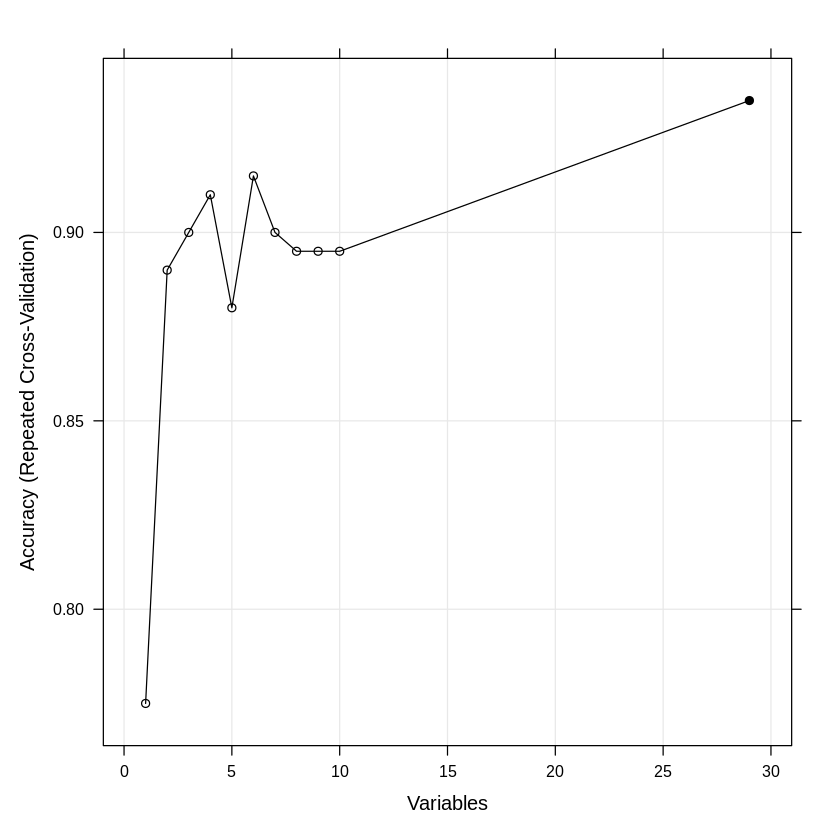

In [15]:
trellis.par.set(caretTheme())
plot(result_rfe_disease_staging, type = c("g", "o"))

### nn

In [145]:
metadata_psvd_cneg$group_123 <- as.factor(metadata_psvd_cneg$group_123)

In [146]:
roc_control = trainControl(method = 'LOOCV',                
                        number = 1,
                         savePredictions = 'final',        
                        ) # number of folds

nnetGrid <-  expand.grid(size = seq(from = 5, to = 10, by = 1),
                        decay = seq(from = 0.1, to = 2.5, by = 0.1))

roc_pred_stage <- train(group_123 ~ HMDB0000036 + HMDB0000191 + HMDB0000299 + HMDB0000448 + HMDB0007890 + HMDB0009009, 
                 data = metadata_psvd_cneg,
                 method = "nnet",
                 trControl = roc_control,
                 tuneGrid = nnetGrid)
roc_pred_stage
     

# weights:  41
initial  value 30.108889 
iter  10 value 7.159102
iter  20 value 6.890689
iter  30 value 6.885150
iter  40 value 6.884944
final  value 6.884943 
converged
# weights:  49
initial  value 30.762820 
iter  10 value 7.599556
iter  20 value 6.616127
iter  30 value 6.572858
iter  40 value 6.572365
final  value 6.572353 
converged
# weights:  57
initial  value 30.036008 
iter  10 value 6.956411
iter  20 value 6.521112
iter  30 value 6.460580
iter  40 value 6.459247
final  value 6.459239 
converged
# weights:  65
initial  value 28.144031 
iter  10 value 7.136748
iter  20 value 6.540812
iter  30 value 6.513654
iter  40 value 6.511599
final  value 6.511570 
converged
# weights:  73
initial  value 28.589878 
iter  10 value 7.267095
iter  20 value 6.469145
iter  30 value 6.440706
iter  40 value 6.439016
iter  50 value 6.438959
final  value 6.438959 
converged
# weights:  81
initial  value 27.072959 
iter  10 value 6.826211
iter  20 value 6.534526
iter  30 value 6.479577
iter  40 valu

Neural Network 

40 samples
 6 predictor
 2 classes: '1', '3' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 39, 39, 39, 39, 39, 39, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy  Kappa
   5    0.1    0.975     0.95 
   5    0.2    0.975     0.95 
   5    0.3    0.975     0.95 
   5    0.4    0.975     0.95 
   5    0.5    0.975     0.95 
   5    0.6    0.975     0.95 
   5    0.7    0.975     0.95 
   5    0.8    0.975     0.95 
   5    0.9    0.925     0.85 
   5    1.0    0.925     0.85 
   5    1.1    0.875     0.75 
   5    1.2    0.900     0.80 
   5    1.3    0.900     0.80 
   5    1.4    0.875     0.75 
   5    1.5    0.850     0.70 
   5    1.6    0.875     0.75 
   5    1.7    0.850     0.70 
   5    1.8    0.850     0.70 
   5    1.9    0.850     0.70 
   5    2.0    0.850     0.70 
   5    2.1    0.850     0.70 
   5    2.2    0.825     0.65 
   5    2.3    0.800     0.60 
   5    2.4    0.850     0.70 

In [147]:
tmp1 <- metadata_psvd_cneg %>% select(c(group_123, HMDB0000036, HMDB0000191, HMDB0000299, HMDB0000448, HMDB0007890, HMDB0009009))

In [148]:
metadata_psvd_cneg %>% select(c(group_123, HMDB0000036, HMDB0000191, HMDB0000299, HMDB0000448, HMDB0007890, HMDB0009009))

group_123,HMDB0000036,HMDB0000191,HMDB0000299,HMDB0000448,HMDB0007890,HMDB0009009
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.685192919,1.6773261,0.31128856,-0.135258331,-0.55690016,-3.805109e-01
1,-0.427026816,1.4695695,0.05908365,0.166257613,-0.28484093,-1.190965e-01
1,-0.715121034,1.6600934,0.07480742,-0.063633651,-1.03621710,-4.426576e-05
1,-0.690185891,0.2502914,-0.06247703,-0.364385442,-1.43730346,-1.278740e+00
1,-0.156896821,0.2952406,-0.07282168,0.964105113,-0.96727613,3.402829e-01
1,1.207531747,2.2472515,1.42332264,-0.450134623,-0.58582412,3.120618e-02
1,0.107834655,1.8886140,0.08495526,-0.193410676,-1.58326872,-1.331811e+00
1,-0.613541105,0.8683313,0.06071082,-0.065248333,0.18969881,1.745287e-01
1,-0.409744085,0.8941888,0.14416237,-0.046657081,-0.14166187,-6.932927e-02


In [149]:
tmp <- varImp(roc_pred_stage)$importance %>% tibble::rownames_to_column("feature") %>% arrange(desc(Overall)) %>% select(feature) %>% as.vector()
tmp1 <- roc_pred_stage$train %>% tidyr::pivot_longer(cols = HMDB0000036:HMDB0009009, names_to = "feature", values_to = "value") 
tmp1$feature <- as.factor(tmp1$feature)
levels(tmp1$feature) <- tmp$feature

In [150]:
varImp(roc_pred_stage)

nnet variable importance

            Overall
HMDB0000448 100.000
HMDB0000191  91.820
HMDB0000036  63.605
HMDB0000299   9.975
HMDB0007890   6.870
HMDB0009009   0.000

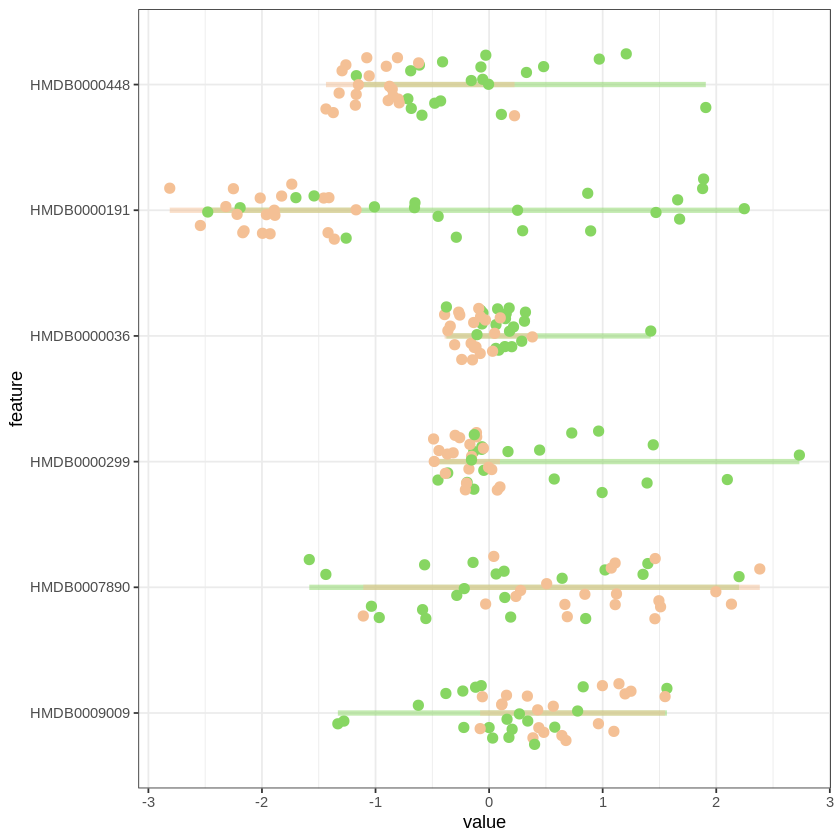

In [151]:
tmp1 %>% 
  ggplot(aes(x = value, y = feature, color = .outcome)) +
  geom_line(alpha = 0.5, size = 1.5) + geom_jitter(size = 2.5, height  = 0.25) +
  theme_bw() +
  theme(legend.position = "none") + scale_color_manual(values = c("#87d662", "#F4C095")) + scale_y_discrete(limits=rev)

Warning message in plot.nnet(roc_pred_stage, hidden = 1, nid = T):
“Using best nnet model from train output”
Warning message in plot.window(...):
“"hidden" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"hidden" is not a graphical parameter”
Warning message in title(...):
“"hidden" is not a graphical parameter”


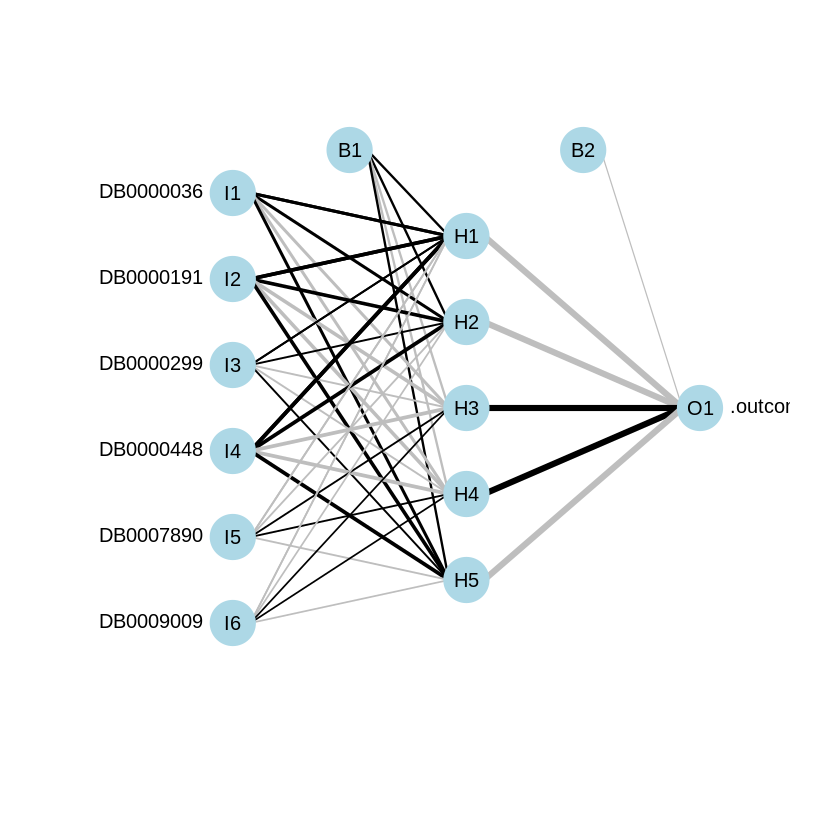

In [152]:

plot.nnet(roc_pred_stage, hidden = 1, nid=T)

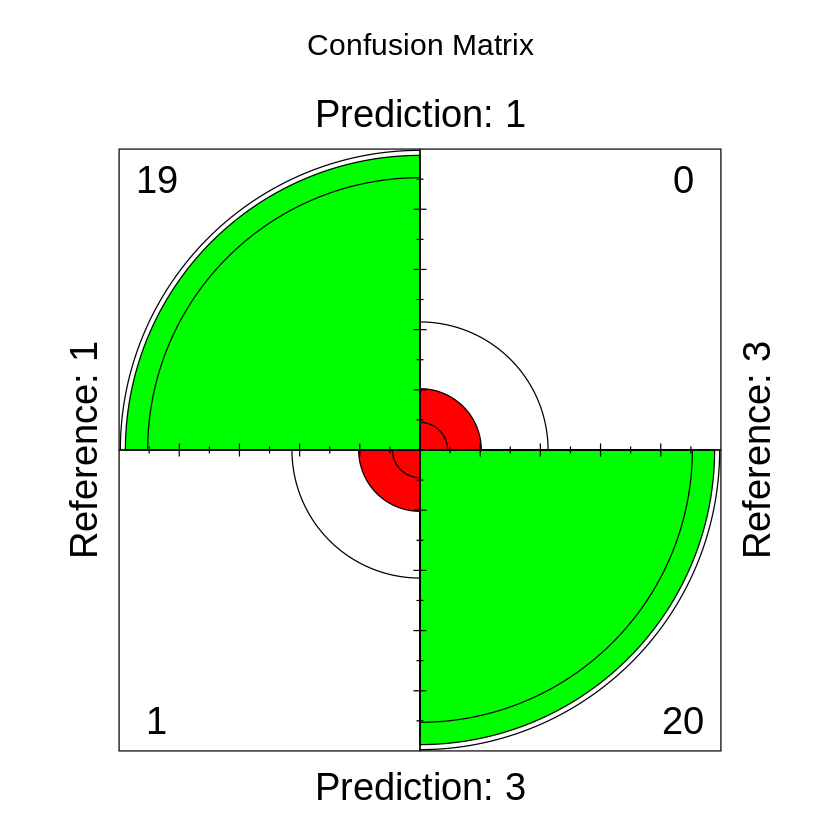

In [153]:
#names(roc_pred_stage)
#roc_pred_stage$pred
tmp_cm <- confusionMatrix(roc_pred_stage$pred$pred, roc_pred_stage$pred$obs)# %>% as.table()
fourfoldplot(tmp_cm %>% as.table(),color=c("red", "green"),main = "Confusion Matrix")

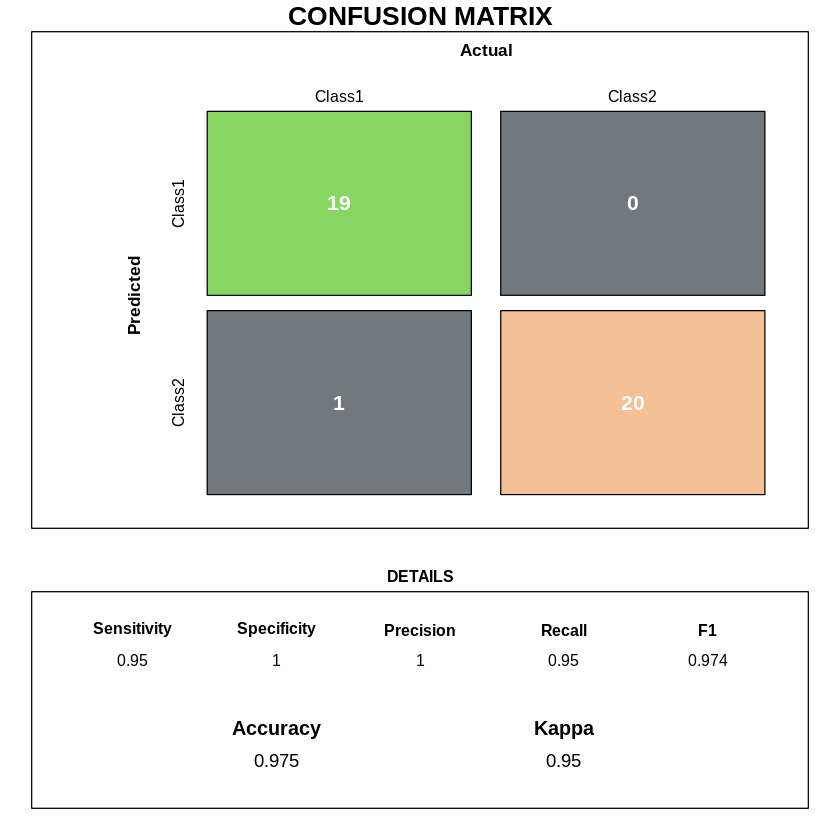

In [154]:
draw_confusion_matrix(tmp_cm)

### svm

In [209]:
#### SVM



roc_control = trainControl(method = 'LOOCV',                
                        number = 3,
                         savePredictions = 'final',        
                        ) # number of folds


roc_pred_stage <- train(group_123 ~ HMDB0000036 + HMDB0000191 + HMDB0000299 + HMDB0000448 + HMDB0007890 + HMDB0009009, 
                 data = metadata_psvd_cneg,
                 method = "svmPoly",
                 trControl = roc_control,
                 preProcess = c("center","scale"),
                 tuneGrid = expand.grid(C = seq(100, 1000, length = 10), degree = 1:3, scale = c(0.1, 1, 10)))
roc_pred_stage

Support Vector Machines with Polynomial Kernel 

40 samples
 6 predictor
 2 classes: '1', '3' 

Pre-processing: centered (6), scaled (6) 
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 39, 39, 39, 39, 39, 39, ... 
Resampling results across tuning parameters:

  degree  scale  C     Accuracy  Kappa
  1        0.1    100  0.975     0.95 
  1        0.1    200  0.975     0.95 
  1        0.1    300  0.975     0.95 
  1        0.1    400  0.975     0.95 
  1        0.1    500  0.975     0.95 
  1        0.1    600  0.975     0.95 
  1        0.1    700  0.975     0.95 
  1        0.1    800  0.975     0.95 
  1        0.1    900  0.975     0.95 
  1        0.1   1000  0.975     0.95 
  1        1.0    100  0.975     0.95 
  1        1.0    200  0.975     0.95 
  1        1.0    300  0.975     0.95 
  1        1.0    400  0.975     0.95 
  1        1.0    500  0.975     0.95 
  1        1.0    600  0.975     0.95 
  1        1.0    700  0.975     0.95 
  1        1.0  

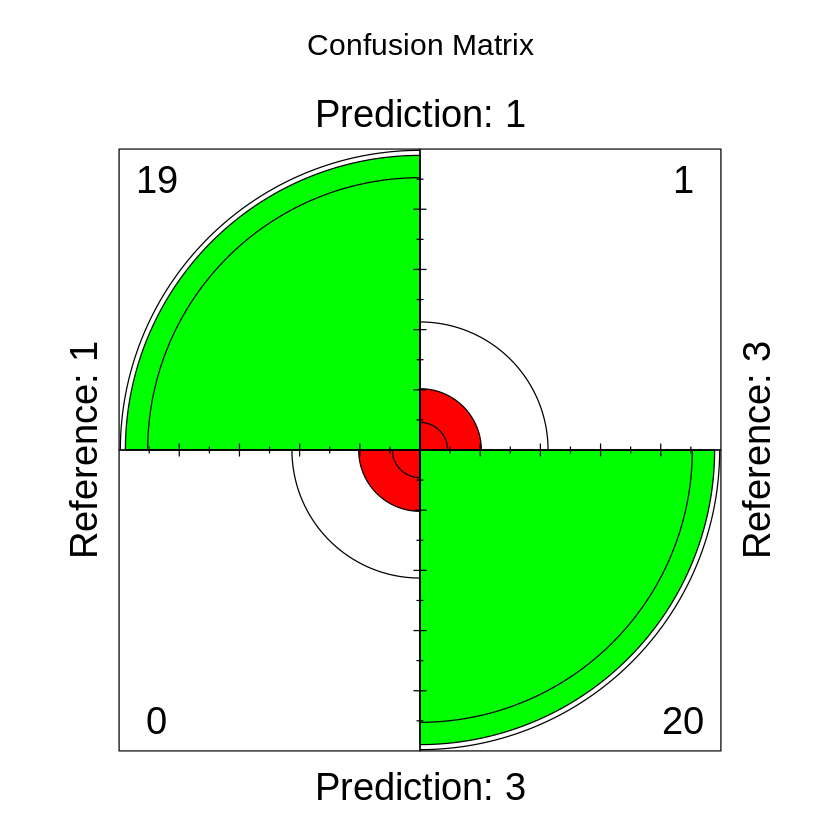

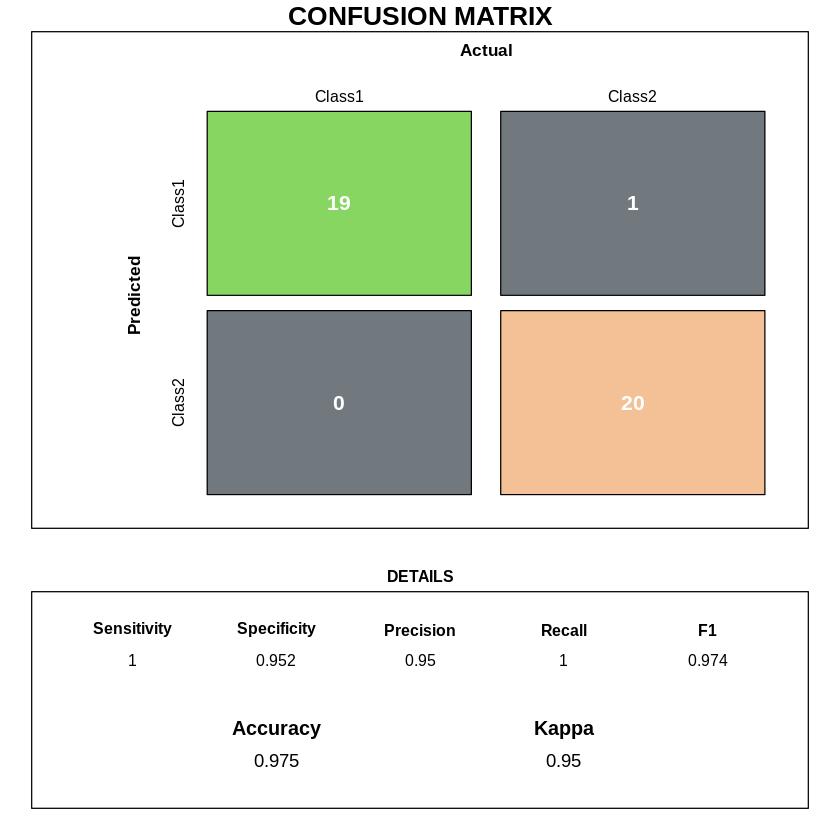

In [210]:
#names(roc_pred_stage)
#roc_pred_stage$pred
tmp_cm <- confusionMatrix(roc_pred_stage$pred$obs, roc_pred_stage$pred$pred)# %>% as.table()
fourfoldplot(tmp_cm %>% as.table(),color=c("red", "green"),main = "Confusion Matrix")
draw_confusion_matrix(tmp_cm)

## PSVD vs cir

### nn

In [121]:
metabol <- read.csv("outputs/01_metabolomics_merged_outliers.csv")
metabol <- metabol[2:ncol(metabol)]
metadata <- read.csv("outputs/01_metadata.csv")
metadata <- metadata[2:ncol(metadata)]

In [122]:
metadata_psvd_cir <- metadata %>% filter(group_123 %in% c(1, 2))
metadata_psvd_cir <- metadata_psvd_cir %>% dplyr::select(-c(LSM, sample_description, group_gen, drug_induced))
metabol <- metabol %>% select_if(~ !any(is.na(.)))
metadata_psvd_cir <- metadata_psvd_cir %>% select_if(~ !any(is.na(.)))
metadata_psvd_cir <- merge(metadata_psvd_cir, metabol, by = "sample_id")
metadata_psvd_cir$group_123 <- as.factor(metadata_psvd_cir$group_123)
x_train <- metadata_psvd_cir[,-2]
y_train <- metadata_psvd_cir[, 2]
     
control_rfe_disease_staging = rfeControl(functions = nbFuncs, # random forest
                      method = "repeatedcv", # repeated cv
                      repeats = 5, # number of repeats
                      number = 10) # number of folds

set.seed(42)
# Performing RFE
defaultW <- getOption("warn") 
options(warn = -1)
result_rfe_disease_staging = rfe(x = x_train %>% dplyr::select(-sample_id), 
                 y = y_train, 
                 sizes = c(1:10),
                 rfeControl = control_rfe_disease_staging)

# result_rfe_disease_staging = train(x = x_train_disease_staging %>% dplyr::select(-Sample_id), 
#                  method = "rf",
#                  y = y_train_disease_staging, 
#                  sizes = c(1:10),
#                  trControl = control_rfe_disease_staging)

# summarising the results
result_rfe_disease_staging
options(warn = defaultW)
result_rfe_disease_staging$optVariables
result_rfe_disease_staging$optVariables %>% as.vector()

     


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy Kappa AccuracySD KappaSD Selected
         1    0.515  0.03     0.2444  0.4888         
         2    0.630  0.26     0.2435  0.4870         
         3    0.585  0.17     0.2702  0.5403         
         4    0.620  0.24     0.2777  0.5555         
         5    0.575  0.15     0.2538  0.5076         
         6    0.580  0.16     0.2227  0.4454         
         7    0.605  0.21     0.2207  0.4414         
         8    0.605  0.21     0.2374  0.4748         
         9    0.595  0.19     0.2469  0.4937         
        10    0.600  0.20     0.2369  0.4738         
       301    0.780  0.56     0.1997  0.3995        *

The top 5 variables (out of 301):
   HMDB0000448, HMDB0000158, HMDB0007872, HMDB0005362, HMDB0009009


[1] "HMDB0000448"         "HMDB0000158"         "HMDB0007872"        
  [4] "HMDB0005362"         "HMDB0009009"         "L29"                
  [7] "L1"                  "HMDB0005376"         "HMDB0000036"        
 [10] "HMDB0000191"         "HMDB0005356"         "HMDB0010395"        
 [13] "HMDB0000564"         "HMDB0005379"         "HMDB0000243"        
 [16] "BL_INR_calc"         "HMDB0010386"         "L58"                
 [19] "HMDB0000205"         "HMDB0000299"         "HMDB0000012"        
 [22] "BX_Alb"              "HMDB0000826"         "HMDB0000143"        
 [25] "HMDB0005432"         "HMDB0008882"         "L65"                
 [28] "HMDB0002183"         "HMDB0005359"         "HMDB0005360"        
 [31] "HMDB0008330"         "HMDB0010419"         "L60"                
 [34] "L15"                 "HMDB0007890"         "HMDB0005357"        
 [37] "HMDB0008625"         "HMDB0007872.1"       "HMDB0011487"        
 [40] "HMDB0007021"         "HMDB0000208"         "HMDB0000638"        
 [43] "HMDB0000689"         "L37"                 "BX_VWF"             
 [46] "HMDB0002074"         "BX_GGT"              "HMDB0009691"        
 [49] "HMDB0000462"         "HMDB0000528"         "HMDB0003229"        
 [52] "HMDB0000168"         "Kynurenic.acid"      "L33"                
 [55] "HMDB0007989"         "HMDB0000568"         "L67"                
 [58] "L63"                 "HMDB0000610"         "HMDB0010412"        
 [61] "HMDB0011496"         "HMDB0008054"         "M5"                 
 [64] "HMDB0000212"         "L20"                 "HMDB0010383"        
 [67] "HMDB0000510"         "HMDB0000641"         "HMDB0007989.1"      
 [70] "HMDB0003518"         "HMDB0000052"         "HMDB0011477"        
 [73] "HMDB0008257"         "HMDB0008055.1"       "HMDB0000042"        
 [76] "HMDB0010393"         "HMDB0000564.1"       "HMDB0001388"        
 [79] "HMDB0008835"         "HMDB0000148"         "L42"                
 [82] "HMDB0008020.1"       "HMDB0009914"         "L54"                
 [85] "L8"                  "BX_Ascites"          "Age"                
 [88] "HMDB0008834"         "L61"                 "L12"                
 [91] "HMDB0000237"         "HMDB0000593.1"       "HMDB0008936"        
 [94] "HMDB0007988.1"       "HMDB0000058"         "L57"                
 [97] "HMDB0010404"         "L69"                 "HMDB0007889.1"      
[100] "HMDB0010411"         "HMDB0005368"         "HMDB0007030"        
[103] "L10"                 "HMDB0000167"         "HMDB0005383"        
[106] "HMDB0000157"         "HMDB0006733"         "L56"                
[109] "HMDB0001043"         "HMDB0006736"         "HMDB0000039"        
[112] "HMDB0002917"         "L13"                 "HMDB0007881.1"      
[115] "HMDB0000159"         "HMDB0005369"         "HMDB0002068"        
[118] "HMDB0000262"         "HMDB0005435"         "L41"                
[121] "HMDB0000254"         "HMDB0005066"         "L36"                
[124] "HMDB0008979"         "L11"                 "HMDB0007869"        
[127] "HMDB0005361"         "L39"                 "BX_ALT"             
[130] "HMDB0012108"         "HMDB0009755"         "HMDB0008132"        
[133] "HMDB0005358"         "HMDB0008930"         "HMDB0008843"        
[136] "BX_Fgen"             "L19"                 "HMDB0007991.1"      
[139] "L64"                 "HMDB0006726"         "Cholic.acid"        
[142] "HMDB0010382.1"       "HMDB0005372"         "M8"                 
[145] "HMDB0002815.1"       "HMDB0007879"         "HMDB0000064"        
[148] "L68"                 "HMDB0007921"         "HMDB0007880.1"      
[151] "HMDB0000511"         "BX_Splenomegalie_01" "HMDB0000562"        
[154] "HMDB0002815"         "L71"                 "BX_AST"             
[157] "HMDB0010383.1"       "HMDB0000725"         "HMDB0010381"        
[160] "L24"                 "HMDB0000251"         "HMDB0009012"        
[163] "M14"                 "HMDB0000535"         "HMDB0000718"        
[166] "L18"                 "HMDB0008057.1

[1] "HMDB0000448"         "HMDB0000158"         "HMDB0007872"        
  [4] "HMDB0005362"         "HMDB0009009"         "L29"                
  [7] "L1"                  "HMDB0005376"         "HMDB0000036"        
 [10] "HMDB0000191"         "HMDB0005356"         "HMDB0010395"        
 [13] "HMDB0000564"         "HMDB0005379"         "HMDB0000243"        
 [16] "BL_INR_calc"         "HMDB0010386"         "L58"                
 [19] "HMDB0000205"         "HMDB0000299"         "HMDB0000012"        
 [22] "BX_Alb"              "HMDB0000826"         "HMDB0000143"        
 [25] "HMDB0005432"         "HMDB0008882"         "L65"                
 [28] "HMDB0002183"         "HMDB0005359"         "HMDB0005360"        
 [31] "HMDB0008330"         "HMDB0010419"         "L60"                
 [34] "L15"                 "HMDB0007890"         "HMDB0005357"        
 [37] "HMDB0008625"         "HMDB0007872.1"       "HMDB0011487"        
 [40] "HMDB0007021"         "HMDB0000208"         "HMDB0000638"        
 [43] "HMDB0000689"         "L37"                 "BX_VWF"             
 [46] "HMDB0002074"         "BX_GGT"              "HMDB0009691"        
 [49] "HMDB0000462"         "HMDB0000528"         "HMDB0003229"        
 [52] "HMDB0000168"         "Kynurenic.acid"      "L33"                
 [55] "HMDB0007989"         "HMDB0000568"         "L67"                
 [58] "L63"                 "HMDB0000610"         "HMDB0010412"        
 [61] "HMDB0011496"         "HMDB0008054"         "M5"                 
 [64] "HMDB0000212"         "L20"                 "HMDB0010383"        
 [67] "HMDB0000510"         "HMDB0000641"         "HMDB0007989.1"      
 [70] "HMDB0003518"         "HMDB0000052"         "HMDB0011477"        
 [73] "HMDB0008257"         "HMDB0008055.1"       "HMDB0000042"        
 [76] "HMDB0010393"         "HMDB0000564.1"       "HMDB0001388"        
 [79] "HMDB0008835"         "HMDB0000148"         "L42"                
 [82] "HMDB0008020.1"       "HMDB0009914"         "L54"                
 [85] "L8"                  "BX_Ascites"          "Age"                
 [88] "HMDB0008834"         "L61"                 "L12"                
 [91] "HMDB0000237"         "HMDB0000593.1"       "HMDB0008936"        
 [94] "HMDB0007988.1"       "HMDB0000058"         "L57"                
 [97] "HMDB0010404"         "L69"                 "HMDB0007889.1"      
[100] "HMDB0010411"         "HMDB0005368"         "HMDB0007030"        
[103] "L10"                 "HMDB0000167"         "HMDB0005383"        
[106] "HMDB0000157"         "HMDB0006733"         "L56"                
[109] "HMDB0001043"         "HMDB0006736"         "HMDB0000039"        
[112] "HMDB0002917"         "L13"                 "HMDB0007881.1"      
[115] "HMDB0000159"         "HMDB0005369"         "HMDB0002068"        
[118] "HMDB0000262"         "HMDB0005435"         "L41"                
[121] "HMDB0000254"         "HMDB0005066"         "L36"                
[124] "HMDB0008979"         "L11"                 "HMDB0007869"        
[127] "HMDB0005361"         "L39"                 "BX_ALT"             
[130] "HMDB0012108"         "HMDB0009755"         "HMDB0008132"        
[133] "HMDB0005358"         "HMDB0008930"         "HMDB0008843"        
[136] "BX_Fgen"             "L19"                 "HMDB0007991.1"      
[139] "L64"                 "HMDB0006726"         "Cholic.acid"        
[142] "HMDB0010382.1"       "HMDB0005372"         "M8"                 
[145] "HMDB0002815.1"       "HMDB0007879"         "HMDB0000064"        
[148] "L68"                 "HMDB0007921"         "HMDB0007880.1"      
[151] "HMDB0000511"         "BX_Splenomegalie_01" "HMDB0000562"        
[154] "HMDB0002815"         "L71"                 "BX_AST"             
[157] "HMDB0010383.1"       "HMDB0000725"         "HMDB0010381"        
[160] "L24"                 "HMDB0000251"         "HMDB0009012"        
[163] "M14"                 "HMDB0000535"         "HMDB0000718"        
[166] "L18"                 "HMDB0008057.1

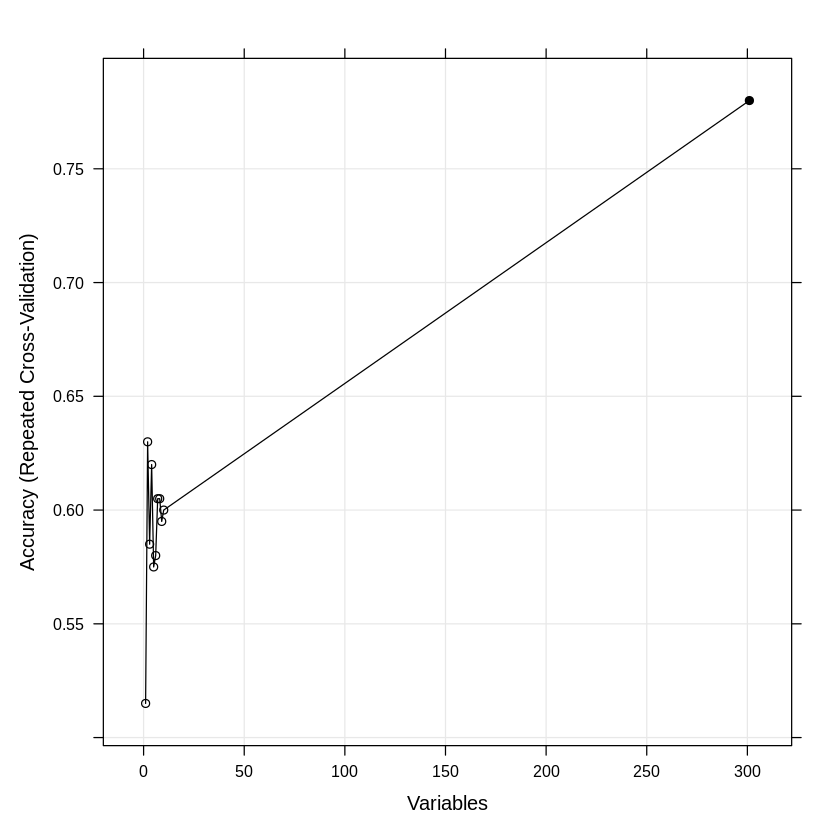

In [123]:
trellis.par.set(caretTheme())
plot(result_rfe_disease_staging, type = c("g", "o"))

In [ ]:
HMDB0000448, HMDB0000158, HMDB0007872, HMDB0005362

In [124]:
best_res <- 4
top_vars <- result_rfe_disease_staging$variables %>% filter(Variables == best_res) %>% arrange(desc(Overall)) %>% distinct(var) %>% head(10)
top_vars <- top_vars$var
top_vars

[1] "HMDB0000448" "HMDB0000158" "L58"         "HMDB0009009" "HMDB0005376"
 [6] "L1"          "HMDB0005362" "L29"         "HMDB0010395" "HMDB0000191"

In [125]:
roc_control = trainControl(method = 'LOOCV',                
                        number = 3,
                         savePredictions = 'final',        
                        ) # number of folds

nnetGrid <-  expand.grid(size = seq(from = 5, to = 10, by = 1),
                        decay = seq(from = 0.1, to = 1.6, by = 0.2))

roc_pred_stage <- train(group_123 ~ HMDB0000448 + HMDB0000158 + HMDB0007872 + HMDB0005362, 
                 data = metadata_psvd_cir,
                 method = "nnet",
                 trControl = roc_control,
                 tuneGrid = nnetGrid)
roc_pred_stage

# weights:  31
initial  value 29.794664 
iter  10 value 13.474080
iter  20 value 13.379601
iter  30 value 13.379061
final  value 13.379058 
converged
# weights:  37
initial  value 25.782141 
iter  10 value 13.501856
iter  20 value 13.299750
iter  30 value 13.296409
final  value 13.296400 
converged
# weights:  43
initial  value 28.801535 
iter  10 value 13.581945
iter  20 value 13.271119
iter  30 value 13.262249
iter  40 value 13.262216
iter  40 value 13.262216
iter  40 value 13.262216
final  value 13.262216 
converged
# weights:  49
initial  value 35.109308 
iter  10 value 13.392575
iter  20 value 13.193696
iter  30 value 13.188458
iter  40 value 13.188391
final  value 13.188390 
converged
# weights:  55
initial  value 27.615965 
iter  10 value 13.609821
iter  20 value 13.185754
iter  30 value 13.169713
iter  40 value 13.169308
iter  50 value 13.169295
iter  50 value 13.169295
iter  50 value 13.169295
final  value 13.169295 
converged
# weights:  61
initial  value 29.559707 
iter  10 

Neural Network 

40 samples
 4 predictor
 2 classes: '1', '2' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 39, 39, 39, 39, 39, 39, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy  Kappa
   5    0.1    0.850     0.70 
   5    0.3    0.800     0.60 
   5    0.5    0.825     0.65 
   5    0.7    0.825     0.65 
   5    0.9    0.825     0.65 
   5    1.1    0.800     0.60 
   5    1.3    0.800     0.60 
   5    1.5    0.775     0.55 
   6    0.1    0.850     0.70 
   6    0.3    0.800     0.60 
   6    0.5    0.825     0.65 
   6    0.7    0.825     0.65 
   6    0.9    0.800     0.60 
   6    1.1    0.800     0.60 
   6    1.3    0.775     0.55 
   6    1.5    0.775     0.55 
   7    0.1    0.850     0.70 
   7    0.3    0.800     0.60 
   7    0.5    0.825     0.65 
   7    0.7    0.825     0.65 
   7    0.9    0.825     0.65 
   7    1.1    0.800     0.60 
   7    1.3    0.800     0.60 
   7    1.5    0.775     0.55 

In [126]:
tmp1 <- metadata_psvd_cir %>% select(c(group_123, HMDB0000448, HMDB0000158, HMDB0007872, HMDB0005362))

In [127]:
tmp <- varImp(roc_pred_stage)$importance %>% tibble::rownames_to_column("feature") %>% arrange(desc(Overall)) %>% select(feature) %>% as.vector()
tmp1 <- roc_pred_stage$train %>% tidyr::pivot_longer(cols = HMDB0000448:HMDB0005362, names_to = "feature", values_to = "value") 
#tmp1$feature <- as.factor(tmp1$feature)
#levels(tmp1$feature) <- c("LSM", "HMDB0000448", "L58", "HMDB0000158")

In [95]:
varImp(roc_pred_stage, scale = FALSE)

nnet variable importance

            Overall
HMDB0000448   51.72
HMDB0007872   22.44
HMDB0000158   14.61
HMDB0005362   11.23

In [128]:
tmp1$feature <- as.factor(tmp1$feature)
levels(tmp1$feature) <- c("HMDB0000448", "HMDB0007872", "HMDB0000158", "HMDB0005362")

In [135]:
tmp1 %>% as.data.frame() %>% arrange(desc(value))

.outcome,feature,value
<fct>,<fct>,<dbl>
2,HMDB0005362,3.602673
2,HMDB0005362,3.597300
2,HMDB0005362,3.041514
2,HMDB0000448,3.040355
1,HMDB0007872,2.731970
2,HMDB0000158,2.142298
1,HMDB0007872,2.097644
2,HMDB0000158,2.002728
2,HMDB0005362,1.919708


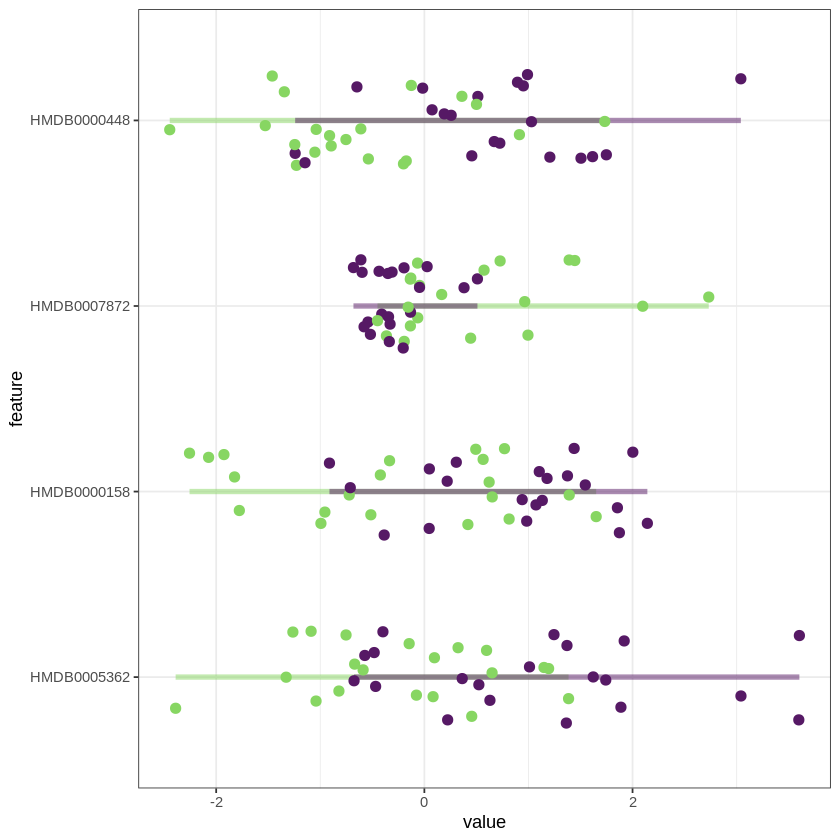

In [130]:
tmp1 %>% 
  ggplot(aes(x = value, y = feature, color = .outcome)) +
  geom_line(alpha = 0.5, size = 1.5) + geom_jitter(size = 2.5, height  = 0.25) +
  theme_bw() +
  theme(legend.position = "none") + scale_color_manual(values = c("#87d662", "#561965")) + scale_y_discrete(limits=rev)

Warning message in plot.nnet(roc_pred_stage, hidden = 1, nid = T):
“Using best nnet model from train output”
Warning message in plot.window(...):
“"hidden" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"hidden" is not a graphical parameter”
Warning message in title(...):
“"hidden" is not a graphical parameter”


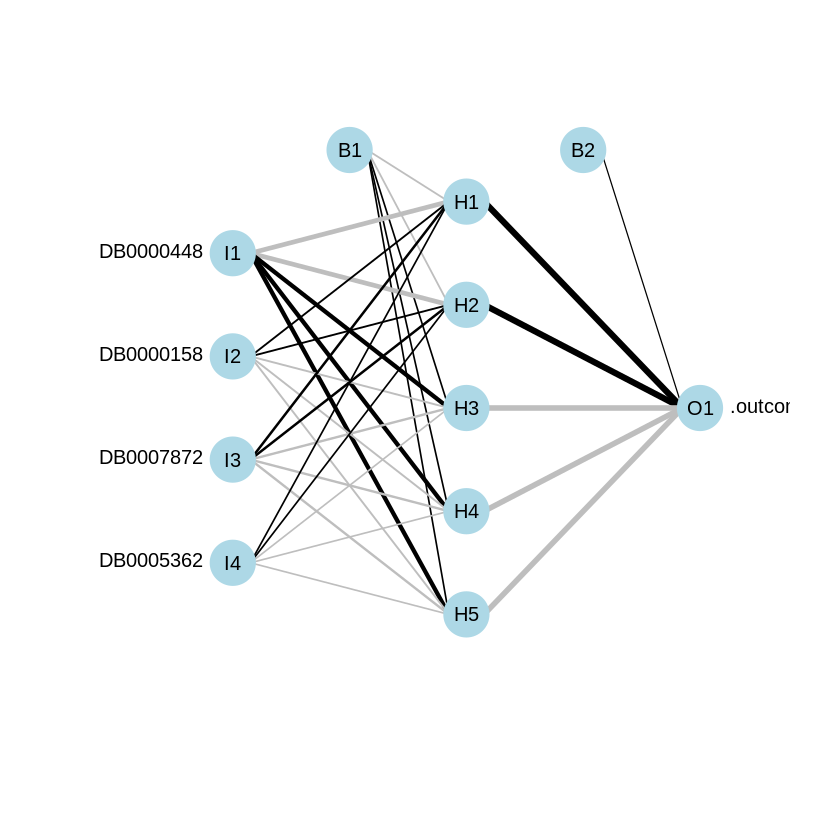

In [102]:

plot.nnet(roc_pred_stage, hidden = 1, nid=T)

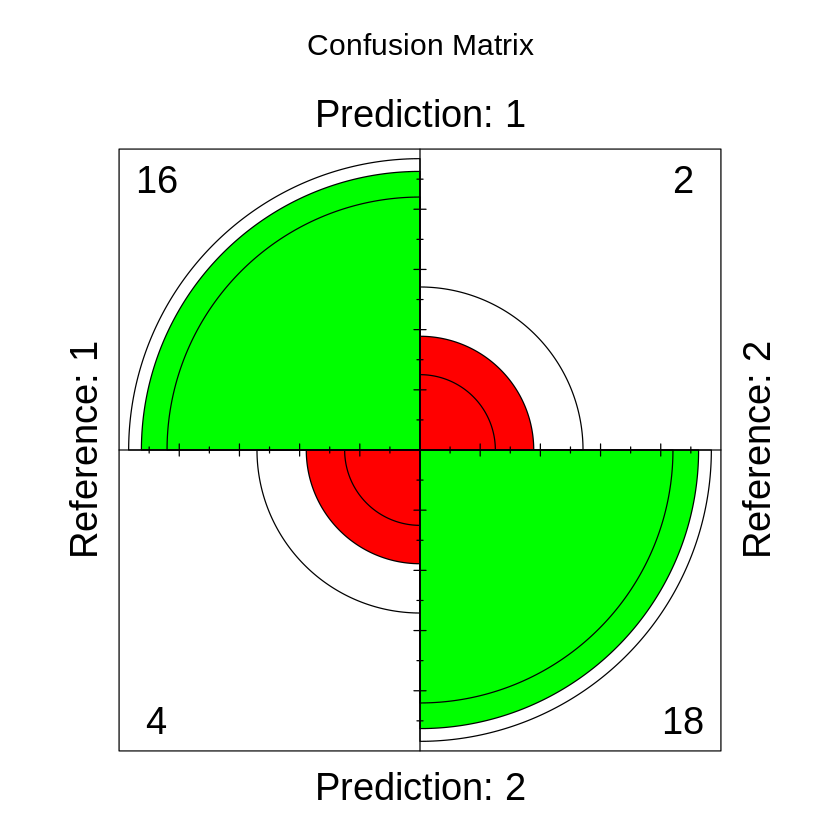

In [136]:
#names(roc_pred_stage)
#roc_pred_stage$pred
tmp_cm <- confusionMatrix(roc_pred_stage$pred$pred, roc_pred_stage$pred$obs)# %>% as.table()
fourfoldplot(tmp_cm %>% as.table(),color=c("red", "green"),main = "Confusion Matrix")

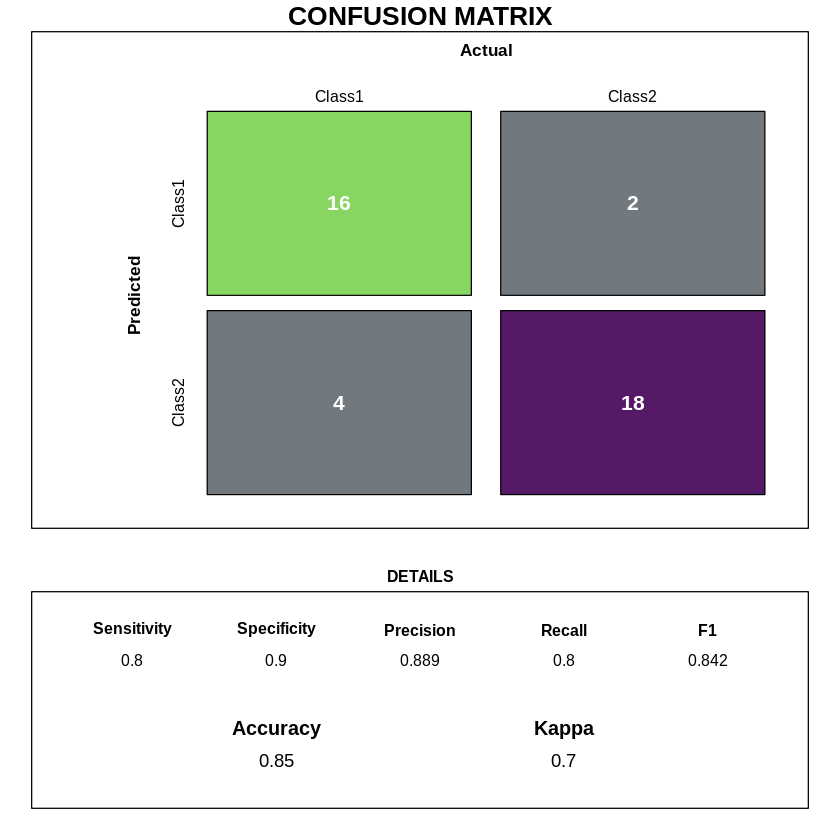

In [143]:
draw_confusion_matrix(tmp_cm)

### svm

In [206]:
#### SVM

roc_control = trainControl(method = 'LOOCV',                
                        number = 3,
                         savePredictions = 'final',        
                        ) # number of folds


roc_pred_stage <- train(group_123 ~ HMDB0000448 + HMDB0000158 + HMDB0007872 + HMDB0005362, 
                 data = metadata_psvd_cir,
                 method = "svmPoly",
                 trControl = roc_control,
                 preProcess = c("center","scale"),
                 tuneGrid = expand.grid(C = seq(100, 1000, length = 10), degree = 1:3, scale = c(0.1, 1, 10)))
roc_pred_stage

Support Vector Machines with Polynomial Kernel 

40 samples
 4 predictor
 2 classes: '1', '2' 

Pre-processing: centered (4), scaled (4) 
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 39, 39, 39, 39, 39, 39, ... 
Resampling results across tuning parameters:

  degree  scale  C     Accuracy  Kappa
  1        0.1    100  0.800     0.60 
  1        0.1    200  0.800     0.60 
  1        0.1    300  0.800     0.60 
  1        0.1    400  0.800     0.60 
  1        0.1    500  0.775     0.55 
  1        0.1    600  0.775     0.55 
  1        0.1    700  0.775     0.55 
  1        0.1    800  0.775     0.55 
  1        0.1    900  0.775     0.55 
  1        0.1   1000  0.775     0.55 
  1        1.0    100  0.775     0.55 
  1        1.0    200  0.775     0.55 
  1        1.0    300  0.775     0.55 
  1        1.0    400  0.775     0.55 
  1        1.0    500  0.775     0.55 
  1        1.0    600  0.775     0.55 
  1        1.0    700  0.775     0.55 
  1        1.0  

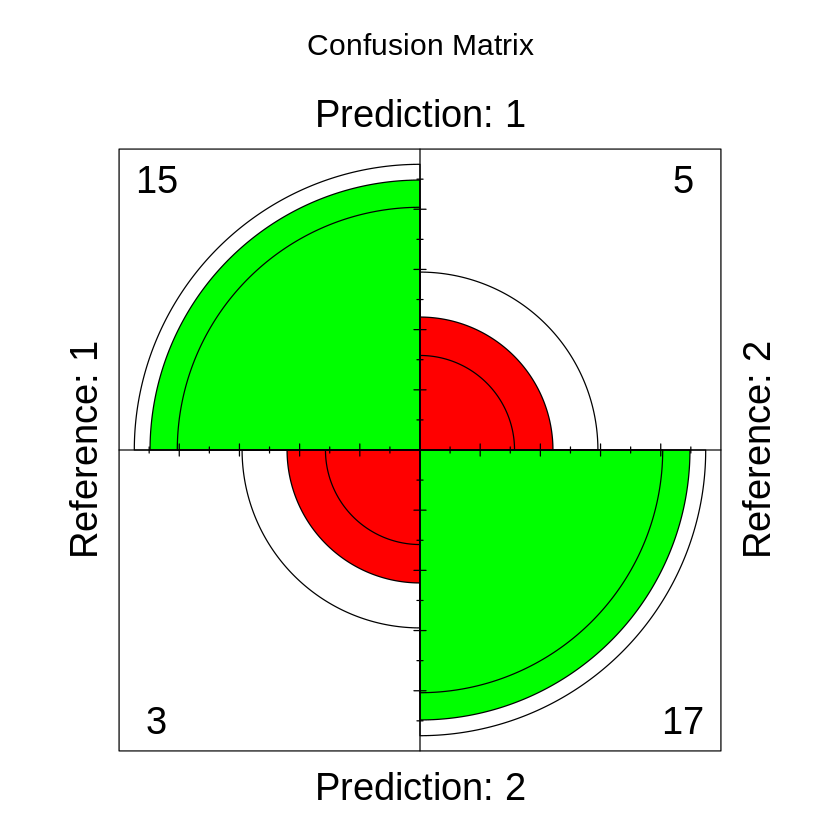

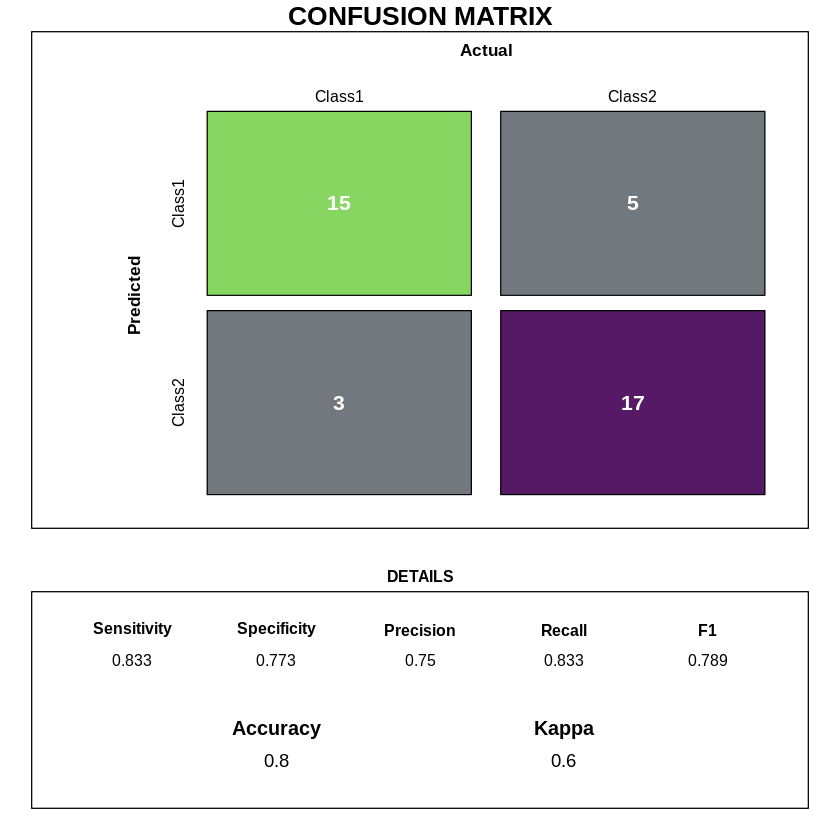

In [207]:
#names(roc_pred_stage)
#roc_pred_stage$pred
tmp_cm <- confusionMatrix(roc_pred_stage$pred$obs, roc_pred_stage$pred$pred)# %>% as.table()
fourfoldplot(tmp_cm %>% as.table(),color=c("red", "green"),main = "Confusion Matrix")
draw_confusion_matrix(tmp_cm)

In [9]:
pred_df <- metadata %>% select(sample_id, sample_description, LSM) %>% filter(!sample_description == "Control")

In [15]:
roc_res <- roc(response = pred_df$sample_description, predictor = pred_df$LSM, levels=c("Cirrhosis", "PSVD"), direction = ">")

In [16]:
roc_res


Call:
roc.default(response = pred_df$sample_description, predictor = pred_df$LSM,     levels = c("Cirrhosis", "PSVD"), direction = ">")

Data: pred_df$LSM in 20 controls (pred_df$sample_description Cirrhosis) > 20 cases (pred_df$sample_description PSVD).
Area under the curve: 0.965

In [18]:
auc(roc_res)
ci(roc_res)

Area under the curve: 0.965

95% CI: 0.8956-1 (DeLong)

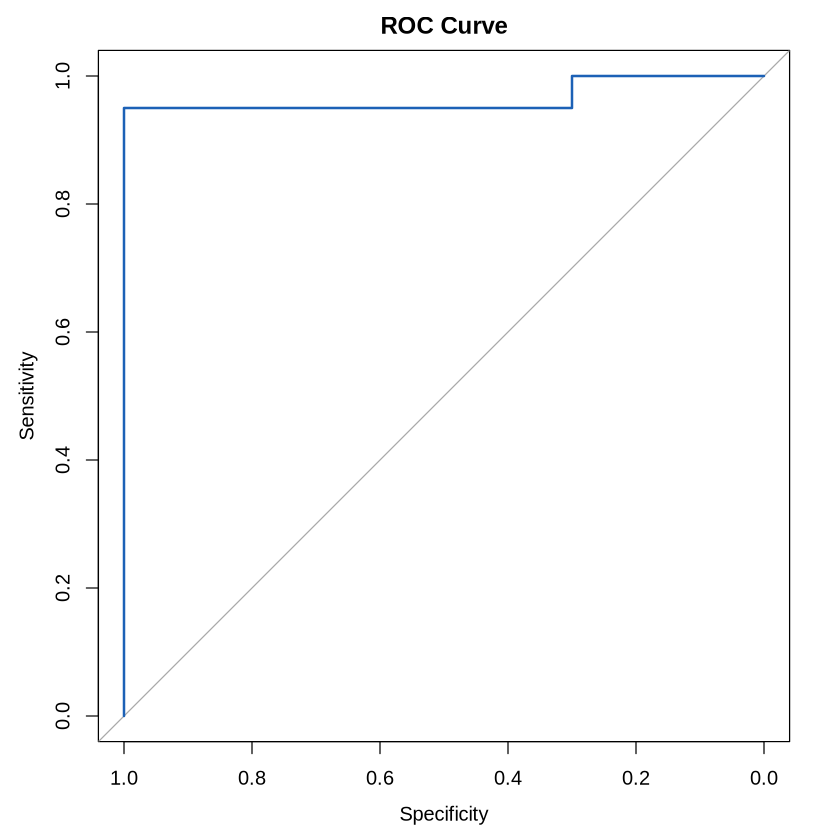

In [19]:
plot(roc_res, main="ROC Curve", col="#1c61b6")